Using device: mps

--- Training EBM with GIBBS (binarized) ---


Epoch 1/10: 100%|██████████| 114/114 [02:32<00:00,  1.33s/it]


[Epoch 1] Avg. CD loss = -1.4858


Epoch 2/10: 100%|██████████| 114/114 [02:31<00:00,  1.33s/it]


[Epoch 2] Avg. CD loss = -10.4390


Epoch 3/10: 100%|██████████| 114/114 [02:32<00:00,  1.34s/it]


[Epoch 3] Avg. CD loss = -13.3540


Epoch 4/10: 100%|██████████| 114/114 [02:31<00:00,  1.33s/it]


[Epoch 4] Avg. CD loss = -6.9956


Epoch 5/10: 100%|██████████| 114/114 [02:30<00:00,  1.32s/it]


[Epoch 5] Avg. CD loss = -4.3523


Epoch 6/10: 100%|██████████| 114/114 [02:31<00:00,  1.33s/it]


[Epoch 6] Avg. CD loss = -5.0740


Epoch 7/10: 100%|██████████| 114/114 [02:32<00:00,  1.34s/it]


[Epoch 7] Avg. CD loss = -7.0607


Epoch 8/10: 100%|██████████| 114/114 [02:30<00:00,  1.32s/it]


[Epoch 8] Avg. CD loss = -9.1514


Epoch 9/10: 100%|██████████| 114/114 [02:34<00:00,  1.36s/it]


[Epoch 9] Avg. CD loss = -11.8667


Epoch 10/10: 100%|██████████| 114/114 [02:49<00:00,  1.48s/it]


[Epoch 10] Avg. CD loss = -14.9754

Sampling from GIBBS-trained EBM...


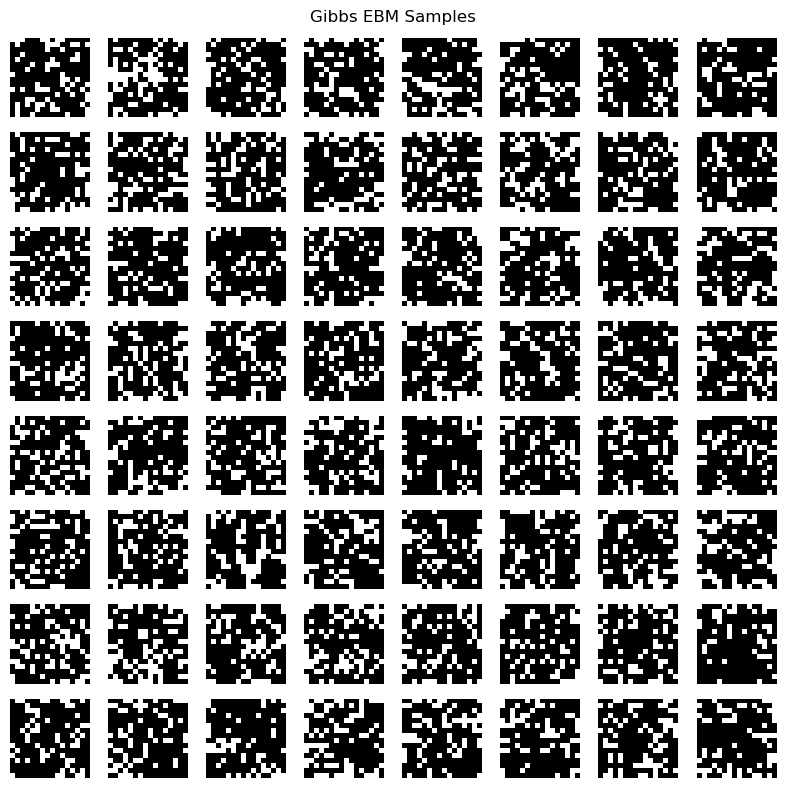


--- Training EBM with LANGEVIN (continuous) ---


Epoch 1/10: 100%|██████████| 114/114 [00:02<00:00, 49.11it/s]


[Epoch 1] Avg. CD loss = -1.4168


Epoch 2/10: 100%|██████████| 114/114 [00:02<00:00, 56.35it/s]


[Epoch 2] Avg. CD loss = -11.9530


Epoch 3/10: 100%|██████████| 114/114 [00:02<00:00, 55.84it/s]


[Epoch 3] Avg. CD loss = -24.8197


Epoch 4/10: 100%|██████████| 114/114 [00:02<00:00, 48.42it/s]


[Epoch 4] Avg. CD loss = -25.7951


Epoch 5/10: 100%|██████████| 114/114 [00:01<00:00, 62.48it/s]


[Epoch 5] Avg. CD loss = -18.1160


Epoch 6/10: 100%|██████████| 114/114 [00:02<00:00, 56.97it/s]


[Epoch 6] Avg. CD loss = -12.3297


Epoch 7/10: 100%|██████████| 114/114 [00:01<00:00, 59.06it/s]


[Epoch 7] Avg. CD loss = -11.1180


Epoch 8/10: 100%|██████████| 114/114 [00:02<00:00, 52.39it/s]


[Epoch 8] Avg. CD loss = -13.1709


Epoch 9/10: 100%|██████████| 114/114 [00:01<00:00, 62.18it/s]


[Epoch 9] Avg. CD loss = -16.7246


Epoch 10/10: 100%|██████████| 114/114 [00:01<00:00, 61.33it/s]


[Epoch 10] Avg. CD loss = -20.2815

Sampling from LANGEVIN-trained EBM...


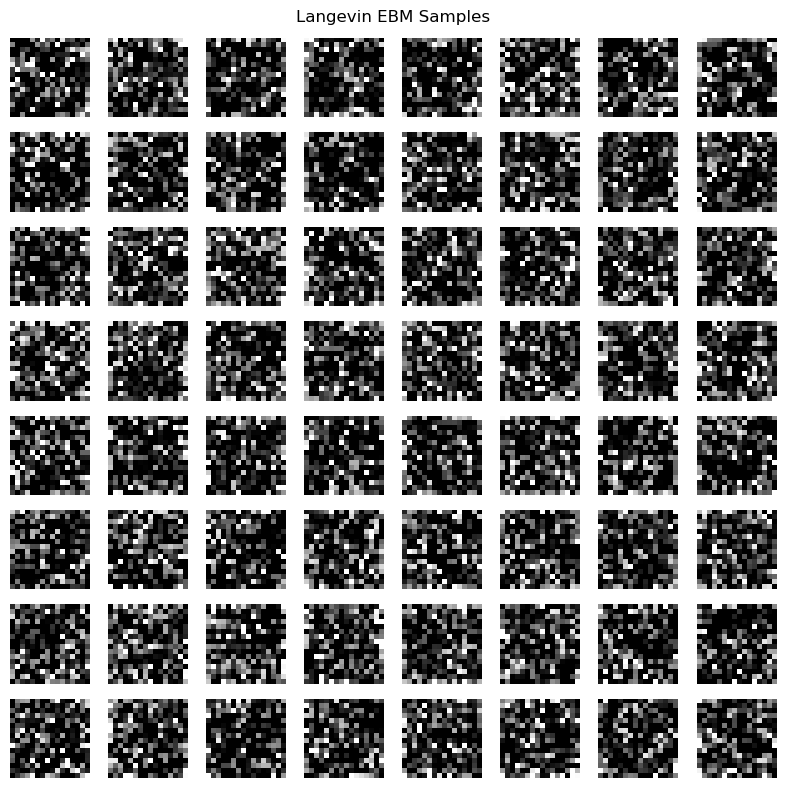

In [ ]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ------------------------------
# 1) HYPERPARAMETERS & SETUP
# ------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps')
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3  # learning rate

print("Using device:", DEVICE)

# ------------------------------
# 2) DATA: USPS
# ------------------------------
# The USPS dataset is 1x16x16 grayscale, range ~ [0..1].
# We'll define two transforms:
#   (A) Binarize for GIBBS => (0 or 1)
#   (B) Keep continuous [0,1] for LANGEVIN
# We'll train two separate models.

transform_bin = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])
transform_flt = transforms.Compose([
    transforms.ToTensor()  # keep [0,1] float
])

train_data_gibbs = datasets.USPS(root='.', train=True, download=True, transform=transform_bin)
train_data_langevin = datasets.USPS(root='.', train=True, download=True, transform=transform_flt)

train_loader_gibbs = DataLoader(train_data_gibbs, batch_size=BATCH_SIZE, shuffle=True)
train_loader_langevin = DataLoader(train_data_langevin, batch_size=BATCH_SIZE, shuffle=True)

# We'll ignore a separate test set here; typically you'd keep some data for validation.

# ------------------------------
# 3) SIMPLE 2-LAYER CNN ENERGY
# ------------------------------
class EnergyModel(nn.Module):
    """
    E(x) = a small 2-layer convolution net => scalar
    for a 1x16x16 input.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (B,1,16,16) => out: shape (B,)
        # conv1 -> ReLU -> conv2 -> average pool to scalar
        h = F.relu(self.conv1(x))     # (B,16,16,16)
        out = self.conv2(h)          # (B,1,16,16)
        # reduce spatially to get a scalar energy
        e = out.mean(dim=[1,2,3])    # mean over channel+height+width => (B,)
        return e

# ------------------------------
# 4) GIBBS SAMPLING (binary)
# ------------------------------
@torch.no_grad()
def gibbs_sample(model, x_init, steps=30):
    """
    Single-site Gibbs for binarized images:
      x in {0,1}, shape (B,1,16,16).
    """
    model.eval()
    x = x_init.clone().detach().to(DEVICE)
    B, _, H, W = x.shape
    for _ in range(steps):
        for r in range(H):
            for c in range(W):
                # Evaluate E with pixel=0 vs pixel=1
                x[:,0,r,c] = 0.
                e0 = model(x)
                x[:,0,r,c] = 1.
                e1 = model(x)

                # Probability pixel=1 ~ exp(-e1) / [exp(-e0) + exp(-e1)]
                e0 = e0.unsqueeze(1)  # => shape (B,1)
                e1 = e1.unsqueeze(1)
                max_val = torch.max(-e0, -e1)
                p0 = torch.exp(-e0 - max_val)
                p1 = torch.exp(-e1 - max_val)
                denom = p0 + p1
                p1 = p1 / denom

                # sample Bernoulli
                coin = torch.rand_like(p1)
                new_val = (coin < p1).float().view(-1)
                x[:,0,r,c] = new_val
    return x

# ------------------------------
# 5) LANGEVIN SAMPLING (continuous)
# ------------------------------
def langevin_sample(model, x_init, steps=30, step_size=0.1):
    """
    x in [0,1], shape (B,1,16,16).
    We'll do gradient-based sampling:
      x <- x - (step_size/2)*grad(E) + sqrt(step_size)*noise
    Then clamp to [0,1].
    Note: cannot use `with torch.no_grad()`, we need gradient wrt x.
    """
    model.eval()
    x = x_init.clone().detach().to(DEVICE)
    x.requires_grad_(True)
    for _ in range(steps):
        energy = model(x).sum()  # sum over batch
        energy.backward()

        grad = x.grad
        # update
        x.data = x.data - 0.5*step_size*grad + torch.sqrt(torch.tensor(step_size, device=DEVICE))*torch.randn_like(x)
        # clamp
        x.data.clamp_(0., 1.)
        x.grad.zero_()
    return x.detach()

# ------------------------------
# 6) CONTRASTIVE DIVERGENCE TRAINING
# ------------------------------
def train_ebm(model, loader, optimizer, mcmc_method="gibbs", mcmc_steps=30, epochs=5):
    """
    L = E_data[E(x_data)] - E_model[E(x_neg)].
    We'll do random init for negative samples each batch (simple CD).
    """
    model.to(DEVICE)
    model.train()

    for epoch in range(1, epochs+1):
        total_loss = 0.0
        total_count= 0
        for real_x, _ in tqdm(loader, desc=f"Epoch {epoch}/{epochs}"):
            real_x = real_x.to(DEVICE)

            # E_data
            E_pos = model(real_x).mean()

            # generate negative
            B = real_x.size(0)
            if mcmc_method == "gibbs":
                # random init in {0,1}
                init_x = torch.rand_like(real_x).round()
                x_neg  = gibbs_sample(model, init_x, steps=mcmc_steps)
            else:
                # random init in [0,1]
                init_x = torch.rand_like(real_x)
                x_neg  = langevin_sample(model, init_x, steps=mcmc_steps)

            E_neg = model(x_neg).mean()

            loss = E_pos - E_neg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss  += loss.item()*B
            total_count += B

        avg_loss = total_loss / total_count
        print(f"[Epoch {epoch}] Avg. CD loss = {avg_loss:.4f}")

# ------------------------------
# 7) SAMPLING UTILS
# ------------------------------
def plot_samples(images, title="", n=8):
    """
    images: (B,1,16,16) in [0,1] or {0,1}.
    """
    images = images.detach().cpu().numpy()
    B = images.shape[0]
    import math
    rows,cols = n,n
    fig,axes = plt.subplots(rows, cols, figsize=(cols,rows))
    idx=0
    for i in range(rows):
        for j in range(cols):
            if idx < B:
                axes[i,j].imshow(images[idx,0], cmap='gray', vmin=0,vmax=1)
            axes[i,j].axis('off')
            idx+=1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 8) MAIN SCRIPT
# ------------------------------
if __name__ == "__main__":
    print("\n--- Training EBM with GIBBS (binarized) ---")
    model_gibbs = EnergyModel()
    optimizer_gibbs = optim.Adam(model_gibbs.parameters(), lr=LR)
    train_ebm(model_gibbs, train_loader_gibbs, optimizer_gibbs, 
              mcmc_method="gibbs", mcmc_steps=0, epochs=EPOCHS)

    print("\nSampling from GIBBS-trained EBM...")
    with torch.no_grad():
        init_samples = torch.rand(64,1,16,16).round()
        samples_gibbs = gibbs_sample(model_gibbs, init_samples, steps=50)
    plot_samples(samples_gibbs, title="Gibbs EBM Samples", n=8)


    print("\n--- Training EBM with LANGEVIN (continuous) ---")
    model_lang = EnergyModel()
    optimizer_lang = optim.Adam(model_lang.parameters(), lr=LR)
    train_ebm(model_lang, train_loader_langevin, optimizer_lang, 
              mcmc_method="langevin", mcmc_steps=10, epochs=EPOCHS)

    print("\nSampling from LANGEVIN-trained EBM...")
    # Must NOT use no_grad for Langevin, we need grad steps
    # So we'll sample in a function call that doesn't wrap no_grad
    init_samples2 = torch.rand(64,1,16,16)
    samples_lang  = langevin_sample(model_lang, init_samples2, steps=50, step_size=0.1)
    plot_samples(samples_lang, title="Langevin EBM Samples", n=8)
